<h1> Preprocessing Data </h1>

In [1]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

TARGET_SIZE = (64, 64)
data_dir = data_dir = 'C:\\Users\\acer\\OneDrive\\Documents\\College\\Deep Learning\\AksaraJawaHanacaraka\\data_set1'

# Daftar kelas
classes = sorted(os.listdir(data_dir))

# Inisialisasi array untuk gambar dan label
images = []
labels = []

# Mengumpulkan data gambar dan label
for label_idx, label in enumerate(classes):
    class_dir = os.path.join(data_dir, label)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            img = Image.open(img_path)
            if img is not None:
                img = img.convert('L').resize(TARGET_SIZE) 
                img_data = np.array(img) / 255.0
                images.append(img_data)
                labels.append(label_idx)
            else:
                print(f"Gambar {img_path} tidak valid, diabaikan.")
        except (UnidentifiedImageError, OSError):
            print(f"Gambar {img_path} tidak dapat dibaca, diabaikan.")

# Konversi ke format NumPy
images = np.array(images)
labels = np.array(labels)

# One-hot encoding
num_classes = len(classes)
labels = to_categorical(labels, num_classes=num_classes)

# Pembagian data train dan test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test: {len(X_test)}")

Jumlah data train: 2960
Jumlah data test: 740


<h1> Model Autoencoder </h1>

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(norm2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(norm3)
    encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    return encoded

def decoder(encoded):
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2, 2))(conv6)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

# Input shape
input_shape = (64, 64, 1)

# Input tensor
input_img = Input(shape=input_shape)

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0     

<h1> Training Autoencoder </h1>

Epoch 1/40
24/24 [==============================] - 36s 1s/step - loss: 0.0996 - val_loss: 0.6053
Epoch 2/40
24/24 [==============================] - 32s 1s/step - loss: 0.0547 - val_loss: 0.4681
Epoch 3/40
24/24 [==============================] - 32s 1s/step - loss: 0.0529 - val_loss: 0.2901
Epoch 4/40
24/24 [==============================] - 32s 1s/step - loss: 0.0502 - val_loss: 0.1642
Epoch 5/40
24/24 [==============================] - 35s 1s/step - loss: 0.0480 - val_loss: 0.1311
Epoch 6/40
24/24 [==============================] - 31s 1s/step - loss: 0.0453 - val_loss: 0.1260
Epoch 7/40
24/24 [==============================] - 32s 1s/step - loss: 0.0436 - val_loss: 0.1303
Epoch 8/40
24/24 [==============================] - 31s 1s/step - loss: 0.0424 - val_loss: 0.1362
Epoch 9/40
24/24 [==============================] - 31s 1s/step - loss: 0.0418 - val_loss: 0.1201
Epoch 10/40
24/24 [==============================] - 31s 1s/step - loss: 0.0405 - val_loss: 0.1196
Epoch 11/40
24/24 [

c:\Users\acer\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


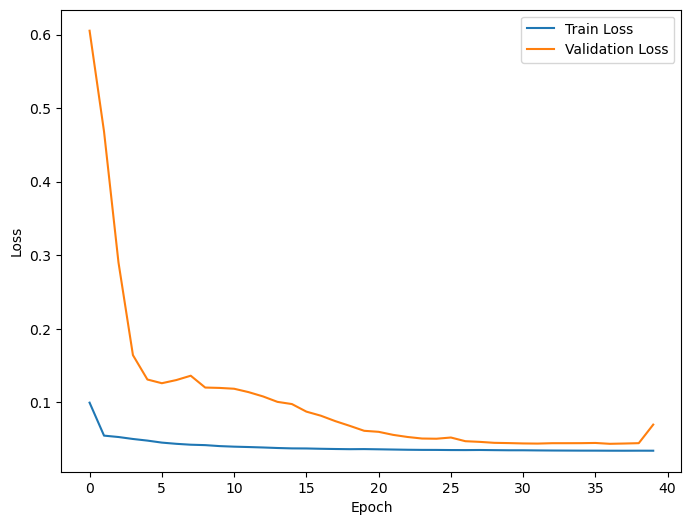

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = autoencoder.fit(X_train, X_train,
                          epochs=40,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=[early_stopping])

# Save the trained model
autoencoder.save('autoencoder.h5')

# Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h1> Ekstraksi Fitur </h1>

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

autoencoder = load_model('autoencoder.h5')

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv2d_5').output)

# Extract features dari data train
train_features = encoder.predict(X_train)

# Extract features dari data test
test_features = encoder.predict(X_test)

print(f'Shape of train features: {train_features.shape}')
print(f'Shape of test features: {test_features.shape}')

24/24 [==============================] - 1s 39ms/step
Shape of train features: (2960, 16, 16, 64)
Shape of test features: (740, 16, 16, 64)


In [15]:
# Convert ke 1D array 
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

<h1> Klasifikasi SVM </h1>

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(train_features_flat, y_train_1d)

# Prediksi menggunakan data uji
y_pred = svm_model.predict(test_features_flat)

# Evaluasi model
accuracy = accuracy_score(y_test_1d, y_pred)
cm = confusion_matrix(y_test_1d, y_pred)
f1 = f1_score(y_test_1d, y_pred, average='weighted')

print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')

from sklearn.metrics import precision_score, recall_score

# presisi
precision = precision_score(y_test_1d, y_pred, average='weighted')

# recall
recall = recall_score(y_test_1d, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

F1 Score: 0.9103605136461105
Accuracy: 0.9108108108108108
Precision: 0.9139315517366983
Recall: 0.9108108108108108


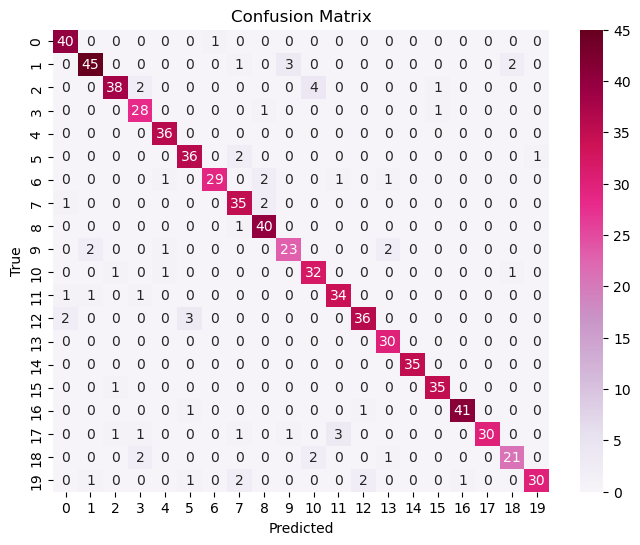

Confusion Matrix:
[[40  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 45  0  0  0  0  0  1  0  3  0  0  0  0  0  0  0  0  2  0]
 [ 0  0 38  2  0  0  0  0  0  0  4  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 28  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  2  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0 29  0  2  0  0  1  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 35  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 40  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  1  0  0  0  0 23  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0  0  0  0 32  0  0  0  0  0  0  0  1  0]
 [ 1  1  0  1  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  3  0  0  0  0  0  0 36  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 35  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menampilkan matriks
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("Confusion Matrix:")
print(cm)


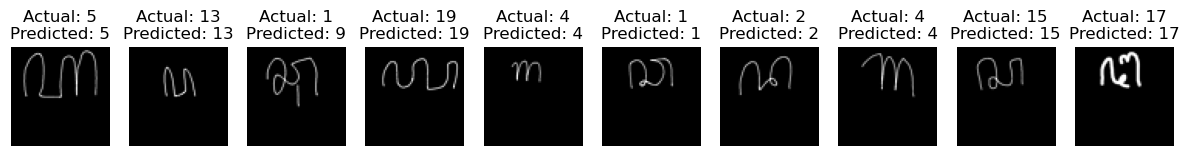

In [18]:
import matplotlib.pyplot as plt

# Mengambil 10 contoh gambar dari data uji
num_images_to_display = 10
sample_images = X_test[:num_images_to_display]
sample_labels = y_test_1d[:num_images_to_display]
predicted_labels = y_pred[:num_images_to_display]

# Menampilkan gambar beserta label dan prediksi
plt.figure(figsize=(15, 5))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(sample_images[i], cmap='binary') 
    plt.title(f'Actual: {sample_labels[i]}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()

<h1> Klasifikasi Random Forest </h1>

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features_flat, y_train_1d)

# Prediksi menggunakan data uji
y_pred_rf = rf_model.predict(test_features_flat)

# Evaluasi model
accuracy_rf = accuracy_score(y_test_1d, y_pred_rf)
cm_rf = confusion_matrix(y_test_1d, y_pred_rf)
f1_rf = f1_score(y_test_1d, y_pred_rf, average='weighted')

print(f'F1 Score Random Forest: {f1_rf}')
print(f'Accuracy Random Forest: {accuracy_rf}')

from sklearn.metrics import precision_score, recall_score

# presisi
precision_rf = precision_score(y_test_1d, y_pred_rf, average='weighted')

# recall
recall_rf = recall_score(y_test_1d, y_pred_rf, average='weighted')

print(f'Precision Random Forest: {precision_rf}')
print(f'Recall Random Forest: {recall_rf}')

F1 Score Random Forest: 0.8964185866441295
Accuracy Random Forest: 0.8959459459459459
Precision Random Forest: 0.9008442275184547
Recall Random Forest: 0.8959459459459459


<h1> Klasifisikasi KNN </h1>

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(train_features_flat, y_train_1d)

# Prediksi menggunakan data uji
y_pred_knn = knn_model.predict(test_features_flat)

# Evaluasi model
accuracy_knn = accuracy_score(y_test_1d, y_pred_knn)
cm_knn = confusion_matrix(y_test_1d, y_pred_knn)
f1_knn = f1_score(y_test_1d, y_pred_knn, average='weighted')

print(f'F1 Score KNN: {f1_knn}')
print(f'Accuracy KNN: {accuracy_knn}')

from sklearn.metrics import precision_score, recall_score

# presisi
precision_rf = precision_score(y_test_1d, y_pred_rf, average='weighted')

# recall
recall_rf = recall_score(y_test_1d, y_pred_rf, average='weighted')

print(f'Precision Random Forest: {precision_rf}')
print(f'Recall Random Forest: {recall_rf}')


F1 Score KNN: 0.6838945901984577
Accuracy KNN: 0.6783783783783783
Precision Random Forest: 0.9008442275184547
Recall Random Forest: 0.8959459459459459


<h2>Klasifikasi Naive Bayes</h2>

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_features_flat, y_train_1d)
y_pred_nb = nb_model.predict(test_features_flat)

# Evaluasi model
accuracy_nb = accuracy_score(y_test_1d, y_pred_nb)
cm_nb = confusion_matrix(y_test_1d, y_pred_nb)
f1_nb = f1_score(y_test_1d, y_pred_nb, average='weighted')
precision_nb = precision_score(y_test_1d, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test_1d, y_pred_nb, average='weighted')

print(f'F1 Score Naive Bayes: {f1_nb}')
print(f'Accuracy Naive Bayes: {accuracy_nb}')
print(f'Precision Naive Bayes: {precision_nb}')
print(f'Recall Naive Bayes: {recall_nb}')

F1 Score Naive Bayes: 0.2928673709858306
Accuracy Naive Bayes: 0.2756756756756757
Precision Naive Bayes: 0.6297965359622172
Recall Naive Bayes: 0.2756756756756757
